# **Task-Informative Signals Selection in BCI using Reinforcement Learning**

## **Member**
1.	Napassorn Techasombooranakit	64340500035
2.	Wasupol Hengsritawat		64340500049

## **Introduction**

In a typical motor imagery (MI)-based EEG acquisition protocol, participants are prompted by a cue signal to perform corresponding motor imagery tasks, generating self-induced MI-EEG data. However, these data may contain unreliable segments if the participant is not fully focused or is experiencing discomfort. Since MI-EEG is sensitive to each individual's mental state, it is difficult to definitively determine when the user is producing intention-related meaningful signals during the EEG acquisition. Currently, there is no system capable of selecting task-relevant data in a supervised manner. Fortunately, Ko et al. have previously introduced a reinforcement-based system framework approach on the KU-MI dataset. This study aims to apply the mentioned framework to the EEG Motor Movement/Imagery Dataset available on PhysioNet.

## **Objective** 

To determine which time points should be utilized (informative) or disregarded (uninformative) when composing intention-related features in a given trial, thus improving the performance of intention identification. Additionally, it aids in enhancing the classification of Motor Imagery (MI) by employing a reinforcement-learning mechanism combined with the existing deep-learning-based brain-computer interface methods.

## **Scopes**

1.	Classification of Motor Imagery (MI) based BCI
    - Classify signals just by imagining the left hand and the right hand only.
    - Use a publicly available motor imagery (MI) dataset.
        - 109 volunteers
        - EEG 64 Channels
        - 3 trials per movement paradigm
    - The validation method of classification performance.
        - Subject-Dependent
        - Subject-Independent
2. Embedding Network and Classification use existing CNN architectures.
    - Shallow ConvNet
3. Reinforcement learning algorithm.
    - Actor-critic network

## **Project Overview**

The system consists of three modules: an embedding module used to extract features from EEG trials, an agent module aimed at selecting task-relevant temporal features, and a classification module, which is a densely connected layer designed to interpret the features into specific motor imagery classes. In this work, the Shallow ConvNet is introduced as the embedding module and actor-critic is the agent module.

![Description of the image](system_overview.png)

Fig 1. Task-informative signal selection system overview

The embedding module and the classification module are pretrained in a supervised manner, without the agent module, by minimizing the cross-entropy loss. The performance obtained from this pretraining serves as baseline information for training the agent module via reinforcement learning. Finally, all modules are trained together until convergence.

In [1]:
import os
import mne
import numpy as np
import warnings
import pyedflib
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from mne.io import concatenate_raws
from autoreject import get_rejection_threshold
from mne.decoding import CSP
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

mne.set_log_level(verbose=False)

# Control GPU consumption
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "True"

## **Subject Independent**

### **Data Preparations**

#### Raw Data

Publicly available motor imagery (MI) dataset from https://www.physionet.org/content/eegmmidb/1.0.0/ 

This dataset use 64-channel EEG and have 14 experimental devide in to 5 part:
1. experiment 1 and 2 is baseline run with eyes open and eyes close in one-minute 
2. experiment 3, 7 and 11 is open and close left or right fist in two-minute
3. experiment 4, 8 and 12 is imagine opening and closing left or right fist in two-minute
4. experiment 5, 9 and 13 is open and close both fists or both feet in two-minute
5. experiment 6, 10 and 14 is imagine opening and closing both fists or both feet in two-minute

Which in this project must use only part 3 is imagine opening and closing left or right fist. It have 3 target is rest left-MI and right-MI but in this projrvt use only left-MI and right-MI and 

First, load raw data from motor imagery (MI) dataset from file path "eeg-motor-movementimagery-dataset-1.0.0/files" and set montage or type of montage is 'standard_1020'

In [2]:
def load_data(subject_id:list, task_id:list, montage_name:str):
    dataset_path = "eeg-motor-movementimagery-dataset-1.0.0/files"

    # --- Full Path ---
    filenames = []
    for i in range(len(subject_id)):
        for j in range(len(task_id)):
            filenames.append("S"+subject_id[i]+"/S"+subject_id[i]+"R"+task_id[j]+".edf")
            
    path = [os.path.join(dataset_path, filename).replace("\\", "/") for filename in filenames]

    # --- Read EDF Files ---
    subject_raws = []
    for file_path in path:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning)
            data = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
        subject_raws.append(data)

    raw_data = concatenate_raws(subject_raws)
    
    with open("eeg-motor-movementimagery-dataset-1.0.0/files/wfdbcal", "r") as file:
        content = file.readlines()
    
    chan_name = []
    chan_order = []
    chan_mapping = {}
    order = 1
    for line in content:
        parts = line.split('\t')
        channel_name = parts[0].strip().upper()
        channel_name = channel_name.replace(".", "")
        channel_name = channel_name.replace("Z", "z")
        channel_name = channel_name.replace("FP1", "Fp1")
        channel_name = channel_name.replace("FP2", "Fp2")
        channel_name = channel_name.replace("FPz", "Fpz")
        chan_name.append(channel_name)
        order_name = "# " + str(order)
        chan_order.append(order_name)
        chan_mapping[order_name] = channel_name
        order += 1 

    channel_names = [chan_mapping[f'# {i+1}'] for i in range(64)]
    old_ch_names = raw_data.ch_names

    raw_data.rename_channels({old: new for old, new in zip(old_ch_names, channel_names)})
    # Set montage
    montage = mne.channels.make_standard_montage('standard_1020')
    raw_data.set_montage(montage)
    
    return raw_data

Load data for subjects of interest, for instance, subjects 1 to 50, and select the following channels is 'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'Cz', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', and 'CPz'. Additionally, choose the targets of interest, specifically 'left' and 'right'.

In [3]:
# --- Data Details --- 
subject_id = []
for i in range(1,51):
    subject_id.append(f'{i:003d}')
    
task_id = ["04", "08", "12"]

# --- Set Montage ---
montage_name = 'standard_1020'

# --- Set Channels Select ---
chans_selected = ['FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6',
                  'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'Cz',
                  'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'CPz']

# --- Set event ---
event = {'left': 2, 'right': 3}
target = ['left','right']
numclass = [2,3]

streams = load_data(subject_id, task_id, montage_name)

In [4]:
streams.get_data().shape

(64, 2961280)

The obtained signals were plotted across 64 channels in the frequency domain, with the X-axis representing Frequency (Hz) and the Y-axis representing power of the Frequency. It can be observed that around the 10 Hz frequency range, there is a noticeable peak that is higher than the surrounding areas. This peak corresponds to the alpha band of brain signals, which is typically used to observe motor imagery signals.

Subsequently, topographic maps were plotted for each frequency band of the signals: Delta, Theta, Alpha, Beta, and Gamma, to identify their respective brain regions. It was observed that the most prominent signals occurred in the Alpha band, specifically within the 8-12 Hz range.

c:\Anaconda\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


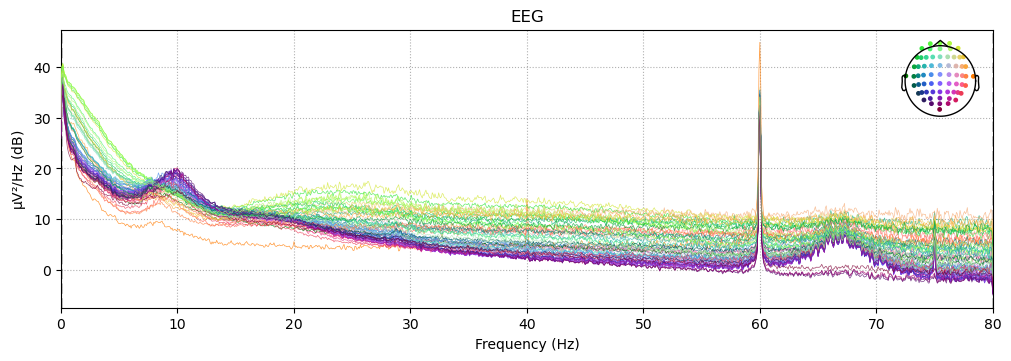

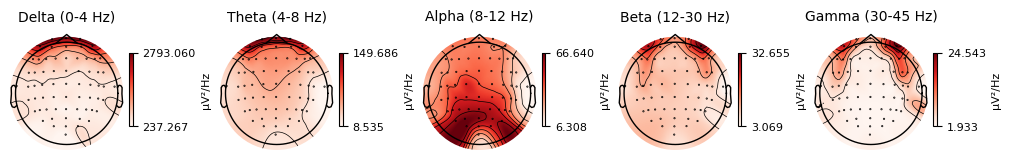

In [5]:
streams.compute_psd().plot();
streams.compute_psd().plot_topomap();

#### Preprocessing

In [6]:
def preprocessing(raws_data, event, chans_selected:list):
    # --- Apply Re-reference by Common Average Reference (CAR) ---
    streams = raws_data.copy().set_eeg_reference('average', projection=True)
    
    # --- Filter Data ---
    stream_filter = streams.copy().filter(l_freq=8.0, h_freq=15.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'})
    
    # --- Apply ICA ---
    ica = mne.preprocessing.ICA(n_components=63, random_state=97, max_iter=800)
    ica.fit(stream_filter.copy())
    
    # --- Find Bad Components ---
    bad_idx, scores = ica.find_bads_eog(stream_filter.copy(), ch_name='T9', threshold=1.5)
    
    # --- Remove Bad Components ---
    ica.exclude = bad_idx
    
    # --- Apply ICA to Filtered Data ---
    stream_ica = ica.apply(stream_filter.copy(),exclude=ica.exclude)
    
    # --- Events ---
    events, event_dict = mne.events_from_annotations(stream_filter)
    
    # --- Epoch ---
    epochs = mne.Epochs(stream_ica.copy().filter(l_freq=8, h_freq=15.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'}), events, tmin = -0.5, tmax = 4, 
                    event_id = event, preload= True, verbose=False, event_repeated='drop')
    
    # --- Selected channels are interested ---
    if chans_selected != 'all':
        epochs = epochs.pick_channels(chans_selected, ordered = False)
    
    # --- Baseline Correction ---
    Baseline = epochs.copy().filter(l_freq=8.0, h_freq=15.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'})
    stream_mi = Baseline.copy().apply_baseline((-0.5, 0))
    
    # --- reject bad channels ---
    def autoreject_epochs(epochs):
        reject = get_rejection_threshold(epochs)  
        reject.update(reject)
        epochs.drop_bad(reject = reject)
        return epochs
    stream_mi = autoreject_epochs(stream_mi.copy())
    
    return stream_mi

In [7]:
epochs = preprocessing(streams, event, chans_selected)
epochs

Estimating rejection dictionary for eeg


Number of events,450
Events,left: 231right: 219
Time range,-0.500 – 4.000 s
Baseline,-0.500 – 0.000 s


The signals were filtered to focus on the 8-15 Hz range, which encompasses the Alpha band where a peak was observed in the pre-filtering graph. As depicted in the graph below, there is a reduction in power for frequencies below 8 Hz and above 15 Hz.

c:\Anaconda\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


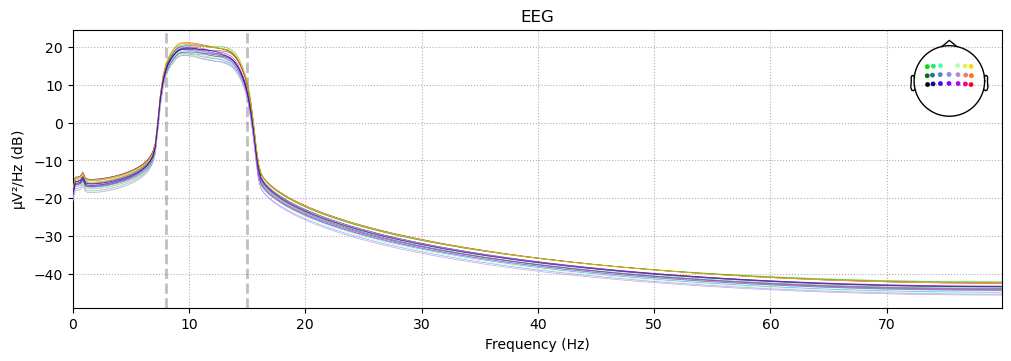

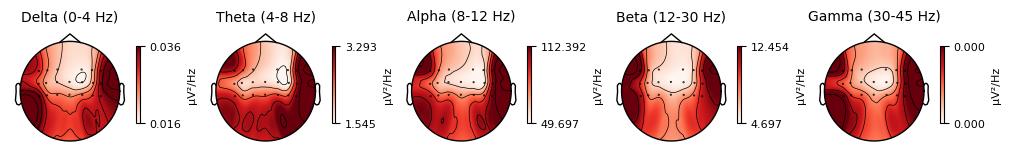

In [8]:
epochs.compute_psd().plot()
epochs.compute_psd().plot_topomap();

The data was reshaped to the dimensions (number of data points or epochs, number of selected channels, number of samples per epoch, 1).

In [9]:
data = epochs.get_data(copy=True)

train_X = np.expand_dims(np.moveaxis(data, 0, 0), -1)
train_X.shape

(450, 20, 721, 1)

In [10]:
encoder = OneHotEncoder(sparse_output=False)

y = epochs.events[:, -1]
y = encoder.fit_transform(np.array(y).reshape(-1, 1))
y.shape

(450, 2)

Split data to train and test

In [11]:
X_train, X_test, y_train, y_test = train_test_split(train_X, y, test_size=0.35, random_state=42)
print(f'Number of train set = {X_train.shape[0]}')
print(f'Number of  test set = {X_test.shape[0]}')

Number of train set = 292
Number of  test set = 158


### **Embedded Module**

##### **Shallow ConvNet**

The Shallow ConvNet, a convolutional neural network architecture for processing raw EEG signals, was introduced by Schirrmeister et al. [3]. Inspired by the Filter Bank Common Spatial Patterns (FBCSP)—a widely used method for decoding EEG data—the Shallow ConvNet comprises two convolutional layers: a temporal convolutional layer and a spatial convolutional layer, each utilizing a square activation function

![Description of the image](shallow_convnet.png)

Fig 2. Shallow ConvNet architecture

##### **Common Spatial Pattern**

The Common Spatial Pattern (CSP), a feature extraction method that uses spatial filters to maximize the discriminability or maximum differences in variance of two classes. CSP algorithm has been widely used for feature extraction in EEG-based BCI systems for motor imagery (MI). CSP was used to separate the sources of the electrodes and indicate the power at each electrode position over different time periods.

![Description of the image](csp_pre.png)
![Description of the image](csp_post.png)

Fig 3. Before and after use Common Spatial Pattern (CSP)

![Description of the image](csp.png)

Fig 3. Common Spatial Pattern (CSP)

In [12]:
class Shallow_convnet(tf.keras.Model):
    tf.keras.backend.set_floatx("float64")
    def __init__(self):
        super(Shallow_convnet, self).__init__()
        self.C = len(chans_selected) # the number of electrodes
        self.fs = 160 # the sampling frequency

        # Regularizer
        self.regularizer = tf.keras.regularizers.L1L2(l1=.001, l2=.01)

        # Activation functions
        square = lambda x: x**2
        self.activation = tf.keras.layers.Activation(square)
        self.softmax = tf.keras.layers.Softmax()
        
        # Define convolutions
        conv = lambda D, kernel : tf.keras.layers.Conv2D(D, kernel, kernel_regularizer=self.regularizer)
        
        # Temporal convoltuion
        self.conv0t = conv(40, (1, int(self.fs/10)))
        
        # Spatial convolution
        self.conv0s = conv(40, (self.C, 1))
        
        # Flatteninig
        self.flatten = tf.keras.layers.Flatten()

        # Dropout
        self.dropout = tf.keras.layers.Dropout(0.5)

        # Decision making
        self.dense = tf.keras.layers.Dense(2, activation=None, kernel_regularizer=self.regularizer)

    def embedding(self, x):
        x = self.conv0t(x)
        f1 = self.activation(self.conv0s(x))

        feature = tf.concat((f1), -1)
        return feature

    def classifier(self, feature):
        # Flattening, dropout, mapping into the decision nodes
        feature = self.flatten(feature)
        feature = self.dropout(feature)
        y_hat = self.softmax(self.dense(feature))
        return y_hat

    def GAP(self, feature):
        return tf.reduce_mean(feature, -2)

    def call(self, x):
        # Extract feature using ShallowCovNet encoder
        feature = self.embedding(x)

        # Global Average Pooling
        feature = self.GAP(feature)

        # Decision making
        y_hat = self.classifier(feature)
        return y_hat

In [13]:
def gradient(model, inputs, labels, mask=None):
    with tf.GradientTape() as tape:
        if mask is None:
            yhat = model(inputs)
        else:
            feature = model.GAP(model.embedding(inputs) * mask)
            yhat = model.classifier(feature)

        loss = tf.keras.losses.binary_crossentropy(labels, yhat)

    grad = tape.gradient(loss, model.trainable_variables)
    return loss, grad

### **Agent Module**

An agent interacts with the environment defined with a given MI-EEG trial feature vectors **$ \phi = \{\phi_1,...,\phi_{T'} \} ∈ R^{C'×T'×D} $**, where $C'$, $T'$, and $D$  are the dimensions of convolved channels, convolved timepoints, and feature vectors respectively. Let the selected timepoints represented by          $t∈S,S⊂\{1,…,T' \}$, and the selected features vectors $\{\phi_t \}_{(t∈S)}$ carry the most information related to the user intention to perform any MI. The states, actions, state translation, and rewards are defined as follows.

**1. State**

A state $s_t$ $(t=1,…,T' )$ is represent as a vector constructed by concatenating the aggregated feature vectors of the selected up to previous timepoint, and the same but include the feature vector in current timepoint in aggregation as follows:

$$ s_t = Concat\begin{pmatrix}
  AGG(\{\phi_i \}_{(i∈S_{(t-1)} )} ) \\
  AGG(\{\phi_i \}_{(i∈S_{(t-1)} )}∪\phi_t )
 \end{pmatrix}
$$

where the aggregator function is a mean aggregator which defined as

$$ AGG(\{\phi_i \}_{(i∈S_t )} )=\frac{1}{|S_t |}  \sum_{i∈S_t}\phi_i $$
where $|S_t|$ is a cardinality of the set $S_t$. 

**2. Action and State Transition**

An action space is defined for the agent to select (1) or reject (0) the sequence of feature vectors over time. Based on the agent’s action, the set S_t is updated as follows:

$$ 
S_t =
  \begin{cases}
    S_{(t-1)} \cup \{t\} & \quad \text{if } a_t=1\\
    S_{(t-1)}            & \quad \text{otherwise}
  \end{cases}
\
$$


**3. Reward**

Given the binary cross-entropy loss after pretrain session $\mathcal{L}_{GAP}$ as a based information, the reward with respect to action $a_t$ and the corresponding feature vector $AGG(\{\phi_i \}_{(i∈S_t )} )$ is defined as follows:

$$ r_t = \mathcal{L}_{GAP}-\mathcal{L}_t $$

when \mathcal{L}_t is a binary cross-entropy loss when using corresponding feature vector as an input for classifier network. The return is simply defined as

$$ R_t=\sum_{k=0}^{T'}\gamma^k r_{t+k} $$


**4. Actor-Critic Network**

According to Ko et al., an actor-critic model is employed in this framework, wherein the agent operates a policy network as the actor and a value estimation function as the critic. Utilizing a temporal-difference update strategy, the loss function for the critic network is defined as:

$$ \mathcal{L}_t^v = \frac{1}{2}[r_t + \gamma V(s_{t+1};θ_v )-V(s_t;θ_v)]^2 $$

Similarly, the loss function for the actor network is expressed as:

$$ \mathcal{L}_t^π = logπ(a_t│s_t;θ_π)(r_t+ \gamma V(s_{t+1};θ_v)-V(s_t;θ_v)) $$

With these specified loss functions for both networks, the optimal policy can be derived by applying stochastic gradient descent. This approach systematically adjusts the parameters to minimize the loss, hence improving the agent's performance by learning the best actions given various states.


In [14]:
class ACTOR(tf.keras.Model):
    def __init__(self, n_actions=2):
        super().__init__()
        self.actor = tf.keras.layers.Dense(n_actions, activation=None, 
                                          kernel_regularizer=tf.keras.regularizers.L1L2(l1=.001, l2=.01))        
    def call(self, segment):
        return self.actor(segment) # Outputs logit vector.
    
class CRITIC(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.critic = tf.keras.layers.Dense(1, activation=None,
                                           kernel_regularizer=tf.keras.regularizers.L1L2(l1=.001, l2=.01))
    def call(self, segment):
        return tf.keras.activations.sigmoid(self.critic(segment))

In [15]:
def agent_gradient(model, actor, critic, inputs, feature, labels, state, state_next):
    gamma = 0.95 # discount factor
    with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
        loss_FM = tf.keras.losses.binary_crossentropy(labels, model(inputs))
        loss_AM = tf.keras.losses.binary_crossentropy(labels, model.classifier(feature))

        # Reward, r_t
        reward = loss_FM - loss_AM
        # Advantage, A_t
        advantage = reward[:, None] + gamma * critic(state_next) - critic(state)            
        # Critic loss
        critic_loss = 0.5 * tf.math.square(advantage)            
        # Actor loss
        actor_loss = -tf.math.log(tf.nn.softmax(actor(state))) * advantage

    critic_grad = tape1.gradient(critic_loss, critic.trainable_variables)
    # print("critic_grad: ", critic_grad)
    actor_grad = tape2.gradient(actor_loss, actor.trainable_variables)
    return critic_loss, critic_grad, actor_loss, actor_grad, reward

### **Experiments**

In [16]:
class experiment():
    def __init__(self, train_X, train_Y, test_X, test_Y):
        # Load dataset.
        self.Xtr, self.Ytr = train_X, train_Y
        self.Xts, self.Yts = test_X, test_Y
        self.Yts = np.argmax(self.Yts, axis=-1) # To use scikit-learn accuracy function
        
        # Randomize the training dataset.
        rand_idx = np.random.permutation(self.Xtr.shape[0])
        self.Xtr, self.Ytr = self.Xtr[rand_idx, :, :, :], self.Ytr[rand_idx, :]

        # Learning schedules
        self.init_LR = 5e-4
        self.num_epochs_pre = 20 # Pre-training epochs
        self.num_epochs = 26
        self.num_batch = 20
        self.optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=self.init_LR)
        
        # Call optimizer.
        self.num_batch_iter = int(self.Xtr.shape[0]/self.num_batch)
        
    def training_FM(self):
        print(f"Classification without agent module ------\n")
        
        # Call ShallowCovNet.
        shallowcov = Shallow_convnet()
        
        # To record the loss curve.
        loss_FM = []
        for epoch in range(self.num_epochs):
            loss_per_epoch = 0

            for batch in range(self.num_batch_iter):
                # Sample minibatch.
                xb = self.Xtr[batch * self.num_batch : (batch + 1) * self.num_batch, :, :, :]
                yb = self.Ytr[batch * self.num_batch : (batch + 1) * self.num_batch, :]

                # Estimate loss
                loss, grads = gradient(shallowcov, xb, yb)

                # Update the parameters
                self.optimizer.apply_gradients(zip(grads, shallowcov.trainable_variables))
                loss_FM.append(np.mean(loss))
                loss_per_epoch += np.mean(loss)

            loss_per_epoch /= self.num_batch_iter

            # Reporting
            print(f"Iteration {epoch + 1}, Training Loss {loss_per_epoch:>.04f}")
            
        # Test the learned model.
        Ytr_hat = np.argmax(shallowcov(self.Xtr), axis=-1)
        Yts_hat = np.argmax(shallowcov(self.Xts), axis=-1)
        # print(f"\nSubject {self.sbj_idx}, Session {self.sess_idx},\
        print(f"\nTraining accuracy: {accuracy_score(np.argmax(self.Ytr, axis=-1), Ytr_hat)}!")
        print(f"Testing accuracy: {accuracy_score(self.Yts, Yts_hat)}!\n")
        return loss_FM
    
    def training_AM(self):
        print(f"Classification with agent module ---------\n")

        # Call ShallowCovNet.
        shallowcov = Shallow_convnet()
        
        # To record the loss curve.
        loss_AM = []
        # Pre-training without the agent module
        for epoch in range(self.num_epochs_pre):
            loss_per_epoch = 0

            for batch in range(self.num_batch_iter):
                # Sample minibatch.
                xb = self.Xtr[batch * self.num_batch : (batch + 1) * self.num_batch, :, :, :]
                yb = self.Ytr[batch * self.num_batch : (batch + 1) * self.num_batch, :]

                # Estimate loss
                loss, grads = gradient(shallowcov, xb, yb)

                # Update the parameters
                self.optimizer.apply_gradients(zip(grads, shallowcov.trainable_variables))
                loss_AM.append(np.mean(loss))
                loss_per_epoch += np.mean(loss)

            loss_per_epoch /= self.num_batch_iter

            # Reporting
            print(f"Iteration {epoch + 1}, Training Loss {loss_per_epoch:>.04f}")
            
        # Call agent module.
        actor = ACTOR()
        critic = CRITIC()

        reward_history = []
        actor_loss_history = []
        critic_loss_history = []
        
        # Training with the agent module
        for epoch in range(self.num_epochs - self.num_epochs_pre):
            loss_per_epoch = 0
            
            for batch in range(self.num_batch_iter):
                # Sample minibatch.
                xb = self.Xtr[batch * self.num_batch : (batch + 1) * self.num_batch, :, :, :]
                yb = self.Ytr[batch * self.num_batch : (batch + 1) * self.num_batch, :]
                # Extract full segments.
                features = shallowcov.embedding(xb)
                
                agg_wo_current = np.zeros((self.num_batch, features.shape[-1]))
                num_added = np.zeros((self.num_batch, features.shape[-1])) # To estimate the denominator.
                mask = np.zeros(features.shape) # Mask generated by the agent module
                for t in tqdm(range(features.shape[-2] - 1)): # t = 1,...,T'
                    # print('epoch :',epoch, 'batch :', batch, 't :', t)
                    deno1 = np.copy(num_added)
                    deno2 = np.copy(num_added) + 1 # For the features with the current segment.
                    # To avoid zero-division.
                    deno1[deno1 == 0] = 1.
                    
                    agg_w_current = agg_wo_current + features[:, 0, t, :]
                    
                    # Define state, s_t.
                    state = np.concatenate((agg_wo_current/deno1, agg_w_current/deno2), axis=-1)
                    # Get action, a_t.
                    action_probs = actor(state)
                    action = np.tile(tf.random.categorical(action_probs, 1).numpy(), 40) # (5, 112)
                    mask[:, 0, t, :] = action
                    num_added += action
                    
                    # Current feature after action decision, phi_t.
                    deno3 = np.copy(num_added)
                    deno3[deno3 == 0] = 1 # To avoid zero-division.
                    feature = (agg_wo_current + features[:, 0, t, :] * action)/deno3
                    
                    # Define next state, s_{t+1}, temporally.
                    agg_wo_current = feature
                    tmp = agg_wo_current + features[:, 0, t + 1, :]
                    state_next = np.concatenate((agg_wo_current/deno3, tmp/(deno3 + 1)), axis=-1)

                    # Calculate critic and actor loss values
                    critic_loss, critic_grads, actor_loss, actor_grads, reward = agent_gradient(shallowcov, actor, critic, xb, feature, yb, state, state_next)
                    
                    reward_history.append(reward.numpy())
                    actor_loss_history.append(actor_loss.numpy())
                    critic_loss_history.append(critic_loss.numpy())
                    
                    self.optimizer.apply_gradients(zip(critic_grads, critic.trainable_variables))
                    # print("critic :",critic.trainable_variables)
                    self.optimizer.apply_gradients(zip(actor_grads, actor.trainable_variables))
                                        
                # Finally, predict labels of input EEG using the selected segments.                
                # Update the parameters
                loss, grads = gradient(shallowcov, xb, yb, mask)
                self.optimizer.apply_gradients(zip(grads, shallowcov.trainable_variables))
                loss_AM.append(np.mean(loss))
                loss_per_epoch += np.mean(loss)
                
            loss_per_epoch /= self.num_batch_iter

            # Reporting
            print(f"Iteration {epoch + 1 + self.num_epochs_pre}, Training Loss {loss_per_epoch:>.04f}")

        acc = []
        for X, Y in [(self.Xtr, np.argmax(self.Ytr, axis=-1)),(self.Xts, self.Yts)]:
            features = shallowcov.embedding(X)
            agg_wo_current = np.zeros((X.shape[0], features.shape[-1]))
            num_added = np.zeros((X.shape[0], features.shape[-1])) # To estimate the denominator.
            mask = np.zeros(features.shape) # Mask generated by the agent module
            for t in tqdm(range(features.shape[-2] - 1)): # t = 1,...,T'
                # print('epoch :',epoch, 'batch :', batch, 't :', t)
                deno1 = np.copy(num_added)
                deno2 = np.copy(num_added) + 1 # For the features with the current segment.
                # To avoid zero-division.
                deno1[deno1 == 0] = 1.
                
                agg_w_current = agg_wo_current + features[:, 0, t, :]
                
                # Define state, s_t.
                state = np.concatenate((agg_wo_current/deno1, agg_w_current/deno2), axis=-1)
                # Get action, a_t.
                action_probs = actor(state)
                action = np.tile(tf.random.categorical(action_probs, 1).numpy(), 40) # (5, 112)
                mask[:, 0, t, :] = action
                num_added += action
                
                # Current feature after action decision, phi_t.
                deno3 = np.copy(num_added)
                deno3[deno3 == 0] = 1 # To avoid zero-division.
                agg_wo_current = (agg_wo_current + features[:, 0, t, :] * action)/deno3

                yhat = shallowcov.classifier(shallowcov.GAP(shallowcov.embedding(X) * mask))
                Y_hat = np.argmax(yhat, axis=-1)

                acc.append(accuracy_score(Y, Y_hat))

        # print(f"\nSubject {self.sbj_idx}, Session {self.sess_idx}, \
        print(f"\nTraining accuracy: {acc[0]}!")
        print(f"Testing accuracy: {acc[1]}!\n")
        return loss_AM, reward_history, actor_loss_history, critic_loss_history

with tf.device('/gpu:1'):
    exp = experiment(X_train, y_train, X_test, y_test)
    loss_FM = exp.training_FM()
    loss_AM, reward_history, actor_loss_history, critic_loss_history = exp.training_AM()

Classification without agent module ------

Iteration 1, Training Loss 0.6933
Iteration 2, Training Loss 0.6932
Iteration 3, Training Loss 0.6932
Iteration 4, Training Loss 0.6932
Iteration 5, Training Loss 0.6932
Iteration 6, Training Loss 0.6932
Iteration 7, Training Loss 0.6932
Iteration 8, Training Loss 0.6932
Iteration 9, Training Loss 0.6932
Iteration 10, Training Loss 0.6932
Iteration 11, Training Loss 0.6932
Iteration 12, Training Loss 0.6932
Iteration 13, Training Loss 0.6932
Iteration 14, Training Loss 0.6932
Iteration 15, Training Loss 0.6932
Iteration 16, Training Loss 0.6932
Iteration 17, Training Loss 0.6932
Iteration 18, Training Loss 0.6932
Iteration 19, Training Loss 0.6932
Iteration 20, Training Loss 0.6932
Iteration 21, Training Loss 0.6932
Iteration 22, Training Loss 0.6932
Iteration 23, Training Loss 0.6932
Iteration 24, Training Loss 0.6932
Iteration 25, Training Loss 0.6932
Iteration 26, Training Loss 0.6932

Training accuracy: 0.5068493150684932!
Testing accurac

In [ ]:
np.array(reward_history).shape

(59220, 20)

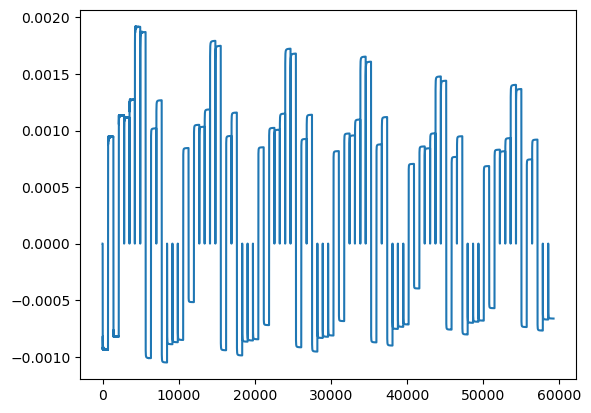

In [ ]:
def training_viz(reward_history, actor_loss_history, critic_loss_history, rolling_length):
    """
    Visualized graphs of episode rewards, episode lengths, and training error during training process
    
    Args:
        rolling_length: Length of the rolling kernel used to convolve the original data
    """
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

    axs[0,0].set_title("Rewards History")
    # compute and assign a rolling average of the data to provide a smoother graph
    reward_moving_average = (
        np.convolve(
            np.array(reward_history).flatten(), np.ones(rolling_length), mode="valid"
        )
        / rolling_length
    )

    batch = [b for b in range(len(reward_moving_average)) if b%705 == 0]

    for i in range(4):
        for b in batch:
            axs[i//2,i%2].axvline(x = b, color = 'gray', linestyle = '--', alpha = 0.5)
    
    axs[0,0].plot(range(len(reward_moving_average)), reward_moving_average)

    axs[0,1].set_title("Actor Training Error Node 1")
    actor_error_moving_average1 = (
        np.convolve(np.array(actor_loss_history[:,0,0]), np.ones(rolling_length), mode="valid")
        / rolling_length
    )
    axs[0,1].plot(range(len(actor_error_moving_average1)), actor_error_moving_average1)

    axs[1,0].set_title("Actor Training Error Node 2")
    actor_error_moving_average2 = (
        np.convolve(np.array(actor_loss_history[:,0,1]), np.ones(rolling_length), mode="valid")
        / rolling_length
    )
    axs[1,0].plot(range(len(actor_error_moving_average2)), actor_error_moving_average2)
    
    axs[1,1].set_title("Critic Training Error")
    critic_error_moving_average = (
        np.convolve(np.array(critic_loss_history), np.ones(rolling_length), mode="valid")
        / rolling_length
    )
    axs[1,1].plot(range(len(critic_error_moving_average)), critic_error_moving_average)
    plt.tight_layout()
    plt.show()

In [ ]:
reward_history = np.array(reward_history)
batch_mean_reward_history = np.mean(reward_history, axis = 1)
actor_loss_history = np.array(actor_loss_history)
critic_loss_history = np.array(critic_loss_history)

batch_mean_reward_log = []
for i in range(int(reward_history.shape[0]/705)):
    batch_mean_reward_log.append(batch_mean_reward_history[i*705:(i+1)*705])

batch_mean_reward_log = np.sum(np.array(batch_mean_reward_log), axis = 1)

In [ ]:
training_viz(reward_history[:,0],actor_loss_history,critic_loss_history[:,0,0],1)

## **Subject Dependent (Shallow Convnet)**

In [ ]:
# --- Data Details --- 
subject_id_d = []
for i in range(1,2):
    subject_id_d.append(f'{i:003d}')
    
task_id_d = ["04", "08", "12"]

# --- Set Montage ---
montage_name_d = 'standard_1020'

# --- Set Channels Select ---
chans_selected_d = ['FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6',
                  'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'Cz',
                  'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'CPz']

# --- Set event ---
event_d = {'left': 2, 'right': 3}
target_d = ['left','right']
numclass_d = [2,3]

streams_d = load_data(subject_id_d, task_id_d, montage_name_d)

In [ ]:
streams_d.get_data().shape

(64, 60000)

c:\Anaconda\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


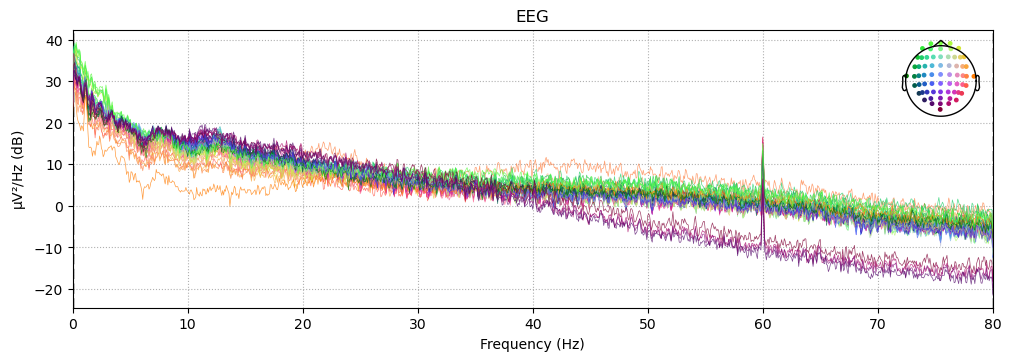

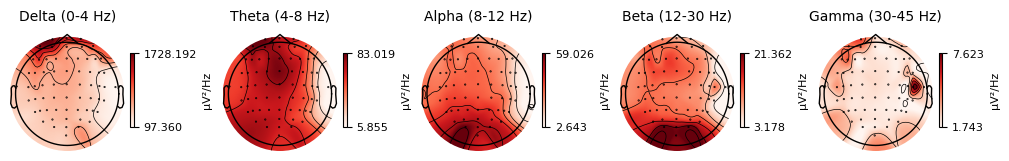

In [ ]:
streams_d.compute_psd().plot();
streams_d.compute_psd().plot_topomap();

In [ ]:
epochs_d = preprocessing(streams_d, event_d, chans_selected_d)
epochs_d

Estimating rejection dictionary for eeg


Number of events,45
Events,left: 23right: 22
Time range,-0.500 – 4.000 s
Baseline,-0.500 – 0.000 s


c:\Anaconda\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


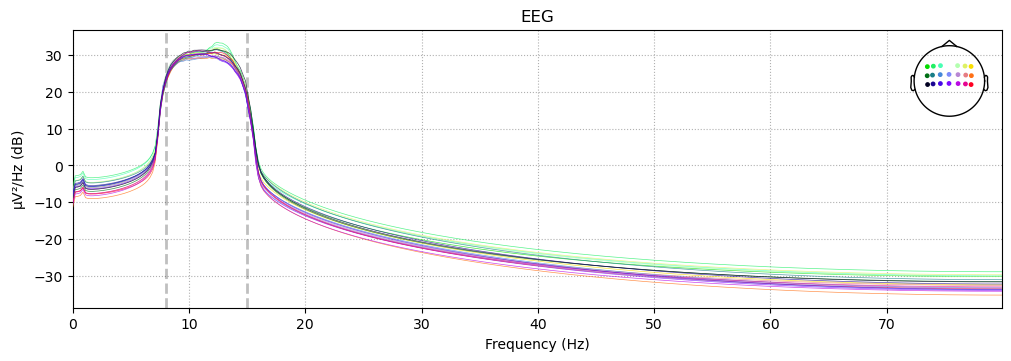

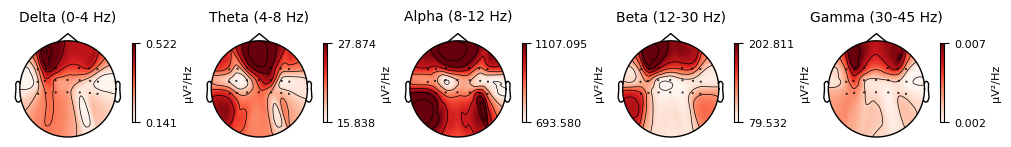

In [ ]:
epochs_d.compute_psd().plot()
epochs_d.compute_psd().plot_topomap();

In [ ]:
data_d = epochs_d.get_data(copy=True)

train_X_d = np.expand_dims(np.moveaxis(data_d, 0, 0), -1)
train_X_d.shape

(45, 20, 721, 1)

In [ ]:
encoder = OneHotEncoder(sparse_output=False)

y_d = epochs_d.events[:, -1]
y_d = encoder.fit_transform(np.array(y_d).reshape(-1, 1))
y_d.shape

(45, 2)

In [ ]:
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(train_X_d, y_d, test_size=0.35, random_state=42)
print(f'Number of train set = {X_train_d.shape[0]}')
print(f'Number of  test set = {X_test_d.shape[0]}')

Number of train set = 29
Number of  test set = 16


In [ ]:
class experiment():
    def __init__(self, train_X, train_Y, test_X, test_Y):
        # Load dataset.
        self.Xtr, self.Ytr = train_X, train_Y
        self.Xts, self.Yts = test_X, test_Y
        self.Yts = np.argmax(self.Yts, axis=-1) # To use scikit-learn accuracy function
        
        # Randomize the training dataset.
        rand_idx = np.random.permutation(self.Xtr.shape[0])
        self.Xtr, self.Ytr = self.Xtr[rand_idx, :, :, :], self.Ytr[rand_idx, :]

        # Learning schedules
        self.init_LR = 5e-4
        self.num_epochs_pre = 20 # Pre-training epochs
        self.num_epochs = 30
        self.num_batch = 20
        self.optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=self.init_LR)
        
        # Call optimizer.
        self.num_batch_iter = int(self.Xtr.shape[0]/self.num_batch)
        
    def training_FM(self):
        print(f"Classification without agent module ------\n")
        
        # Call ShallowCovNet.
        shallowcov = Shallow_convnet()
        
        # To record the loss curve.
        loss_FM = []
        for epoch in range(self.num_epochs):
            loss_per_epoch = 0

            for batch in range(self.num_batch_iter):
                # Sample minibatch.
                xb = self.Xtr[batch * self.num_batch : (batch + 1) * self.num_batch, :, :, :]
                yb = self.Ytr[batch * self.num_batch : (batch + 1) * self.num_batch, :]

                # Estimate loss
                loss, grads = gradient(shallowcov, xb, yb)

                # Update the parameters
                self.optimizer.apply_gradients(zip(grads, shallowcov.trainable_variables))
                loss_FM.append(np.mean(loss))
                loss_per_epoch += np.mean(loss)

            loss_per_epoch /= self.num_batch_iter

            # Reporting
            print(f"Iteration {epoch + 1}, Training Loss {loss_per_epoch:>.04f}")
            
        # Test the learned model.
        Ytr_hat = np.argmax(shallowcov(self.Xtr), axis=-1)
        Yts_hat = np.argmax(shallowcov(self.Xts), axis=-1)
        # print(f"\nSubject {self.sbj_idx}, Session {self.sess_idx},\
        print(f"\nTraining accuracy: {accuracy_score(np.argmax(self.Ytr, axis=-1), Ytr_hat)}!")
        print(f"Testing accuracy: {accuracy_score(self.Yts, Yts_hat)}!\n")
        return loss_FM, shallowcov
    
    def training_AM(self):
        print(f"Classification with agent module ---------\n")

        # Call ShallowCovNet.
        shallowcov = Shallow_convnet()
        
        # To record the loss curve.
        loss_AM = []
        # Pre-training without the agent module
        for epoch in range(self.num_epochs_pre):
            loss_per_epoch = 0

            for batch in range(self.num_batch_iter):
                # Sample minibatch.
                xb = self.Xtr[batch * self.num_batch : (batch + 1) * self.num_batch, :, :, :]
                yb = self.Ytr[batch * self.num_batch : (batch + 1) * self.num_batch, :]

                # Estimate loss
                loss, grads = gradient(shallowcov, xb, yb)

                # Update the parameters
                self.optimizer.apply_gradients(zip(grads, shallowcov.trainable_variables))
                loss_AM.append(np.mean(loss))
                loss_per_epoch += np.mean(loss)

            loss_per_epoch /= self.num_batch_iter

            # Reporting
            print(f"Iteration {epoch + 1}, Training Loss {loss_per_epoch:>.04f}")
            
        # Call agent module.
        actor = ACTOR()
        critic = CRITIC()

        reward_history = []
        actor_loss_history = []
        critic_loss_history = []
        
        # Training with the agent module
        for epoch in range(self.num_epochs - self.num_epochs_pre):
            loss_per_epoch = 0
            
            for batch in range(self.num_batch_iter):
                # Sample minibatch.
                xb = self.Xtr[batch * self.num_batch : (batch + 1) * self.num_batch, :, :, :]
                yb = self.Ytr[batch * self.num_batch : (batch + 1) * self.num_batch, :]
                # Extract full segments.
                features = shallowcov.embedding(xb)
                
                agg_wo_current = np.zeros((self.num_batch, features.shape[-1]))
                num_added = np.zeros((self.num_batch, features.shape[-1])) # To estimate the denominator.
                mask = np.zeros(features.shape) # Mask generated by the agent module
                for t in tqdm(range(features.shape[-2] - 1)): # t = 1,...,T'
                    # print('epoch :',epoch, 'batch :', batch, 't :', t)
                    deno1 = np.copy(num_added)
                    deno2 = np.copy(num_added) + 1 # For the features with the current segment.
                    # To avoid zero-division.
                    deno1[deno1 == 0] = 1.
                    
                    agg_w_current = agg_wo_current + features[:, 0, t, :]
                    
                    # Define state, s_t.
                    state = np.concatenate((agg_wo_current/deno1, agg_w_current/deno2), axis=-1)
                    # Get action, a_t.
                    action_probs = actor(state)
                    action = np.tile(tf.random.categorical(action_probs, 1).numpy(), 40) 
                    mask[:, 0, t, :] = action
                    num_added += action
                    
                    # Current feature after action decision, phi_t.
                    deno3 = np.copy(num_added)
                    deno3[deno3 == 0] = 1 # To avoid zero-division.
                    feature = (agg_wo_current + features[:, 0, t, :] * action)/deno3
                    
                    # Define next state, s_{t+1}, temporally.
                    agg_wo_current = feature
                    tmp = agg_wo_current + features[:, 0, t + 1, :]
                    state_next = np.concatenate((agg_wo_current/deno3, tmp/(deno3 + 1)), axis=-1)

                    # Calculate critic and actor loss values
                    critic_loss, critic_grads, actor_loss, actor_grads, reward = agent_gradient(shallowcov, actor, critic, xb, feature, yb, state, state_next)
                    
                    reward_history.append(reward.numpy())
                    actor_loss_history.append(actor_loss.numpy())
                    critic_loss_history.append(critic_loss.numpy())
                    
                    self.optimizer.apply_gradients(zip(critic_grads, critic.trainable_variables))
                    # print("critic :",critic.trainable_variables)
                    self.optimizer.apply_gradients(zip(actor_grads, actor.trainable_variables))
                                        
                # Finally, predict labels of input EEG using the selected segments.                
                # Update the parameters
                loss, grads = gradient(shallowcov, xb, yb, mask)
                self.optimizer.apply_gradients(zip(grads, shallowcov.trainable_variables))
                loss_AM.append(np.mean(loss))
                loss_per_epoch += np.mean(loss)
                
            loss_per_epoch /= self.num_batch_iter

            # Reporting
            print(f"Iteration {epoch + 1 + self.num_epochs_pre}, Training Loss {loss_per_epoch:>.04f}")

        acc = []
        for X, Y in [(self.Xtr, np.argmax(self.Ytr, axis=-1)),(self.Xts, self.Yts)]:
                yhat = shallowcov.classifier(shallowcov.GAP(shallowcov.embedding(X)))
                Y_hat = np.argmax(yhat, axis=-1)

                acc.append(accuracy_score(Y, Y_hat))

        # print(f"\nSubject {self.sbj_idx}, Session {self.sess_idx}, \
        print(f"\nTraining accuracy: {acc[0]}!")
        print(f"Testing accuracy: {acc[1]}!\n")
        return loss_AM, reward_history, actor_loss_history, critic_loss_history, actor, critic, shallowcov

with tf.device('/gpu:1'):
    exp_d = experiment(X_train_d, y_train_d, X_test_d, y_test_d)
    loss_FM_d, shallowcov_FM_d = exp_d.training_FM()
    loss_AM_d, reward_history_d, actor_loss_history_d, critic_loss_history_d, actor_d, critic_d, shallowcov_AM_d = exp_d.training_AM()

Classification without agent module ------

Iteration 1, Training Loss 0.6931
Iteration 2, Training Loss 0.6927
Iteration 3, Training Loss 0.6923
Iteration 4, Training Loss 0.6919
Iteration 5, Training Loss 0.6914
Iteration 6, Training Loss 0.6906
Iteration 7, Training Loss 0.6894
Iteration 8, Training Loss 0.6875
Iteration 9, Training Loss 0.6849
Iteration 10, Training Loss 0.6814
Iteration 11, Training Loss 0.6773
Iteration 12, Training Loss 0.6725
Iteration 13, Training Loss 0.6673
Iteration 14, Training Loss 0.6622
Iteration 15, Training Loss 0.6575
Iteration 16, Training Loss 0.6535
Iteration 17, Training Loss 0.6507
Iteration 18, Training Loss 0.6489
Iteration 19, Training Loss 0.6479
Iteration 20, Training Loss 0.6476
Iteration 21, Training Loss 0.6475
Iteration 22, Training Loss 0.6475
Iteration 23, Training Loss 0.6474
Iteration 24, Training Loss 0.6474
Iteration 25, Training Loss 0.6474
Iteration 26, Training Loss 0.6474
Iteration 27, Training Loss 0.6474
Iteration 28, Traini

100%|██████████| 705/705 [02:34<00:00,  4.55it/s]


Iteration 21, Training Loss 0.6563


100%|██████████| 705/705 [02:32<00:00,  4.64it/s]


Iteration 22, Training Loss 0.6499


100%|██████████| 705/705 [02:30<00:00,  4.68it/s]


Iteration 23, Training Loss 0.6489


100%|██████████| 705/705 [02:30<00:00,  4.67it/s]


Iteration 24, Training Loss 0.6483


100%|██████████| 705/705 [02:30<00:00,  4.68it/s]


Iteration 25, Training Loss 0.6476


100%|██████████| 705/705 [02:31<00:00,  4.66it/s]


Iteration 26, Training Loss 0.6480


100%|██████████| 705/705 [02:33<00:00,  4.59it/s]


Iteration 27, Training Loss 0.6470


100%|██████████| 705/705 [02:33<00:00,  4.59it/s]


Iteration 28, Training Loss 0.6474


100%|██████████| 705/705 [02:32<00:00,  4.61it/s]


Iteration 29, Training Loss 0.6476


100%|██████████| 705/705 [02:32<00:00,  4.62it/s]

Iteration 30, Training Loss 0.6474

Training accuracy: 0.5517241379310345!
Testing accuracy: 0.4375!



In [ ]:
def training_viz(reward_history, actor_loss_history, critic_loss_history, rolling_length):
    """
    Visualized graphs of episode rewards, episode lengths, and training error during training process
    
    Args:
        rolling_length: Length of the rolling kernel used to convolve the original data
    """
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

    axs[0,0].set_title("Rewards History")
    # compute and assign a rolling average of the data to provide a smoother graph
    reward_moving_average = (
        np.convolve(
            np.array(reward_history).flatten(), np.ones(rolling_length), mode="valid"
        )
        / rolling_length
    )

    batch = [b for b in range(len(reward_moving_average)) if b%705 == 0]

    for i in range(4):
        for b in batch:
            axs[i//2,i%2].axvline(x = b, color = 'gray', linestyle = '--', alpha = 0.5)
    
    axs[0,0].plot(range(len(reward_moving_average)), reward_moving_average)

    axs[0,1].set_title("Actor Training Error Node 1")
    actor_error_moving_average1 = (
        np.convolve(np.array(actor_loss_history[:,0,0]), np.ones(rolling_length), mode="valid")
        / rolling_length
    )
    axs[0,1].plot(range(len(actor_error_moving_average1)), actor_error_moving_average1)

    axs[1,0].set_title("Actor Training Error Node 2")
    actor_error_moving_average2 = (
        np.convolve(np.array(actor_loss_history[:,0,1]), np.ones(rolling_length), mode="valid")
        / rolling_length
    )
    axs[1,0].plot(range(len(actor_error_moving_average2)), actor_error_moving_average2)
    
    axs[1,1].set_title("Critic Training Error")
    critic_error_moving_average = (
        np.convolve(np.array(critic_loss_history), np.ones(rolling_length), mode="valid")
        / rolling_length
    )
    axs[1,1].plot(range(len(critic_error_moving_average)), critic_error_moving_average)
    plt.tight_layout()
    plt.show()

In [ ]:
reward_history_d = np.array(reward_history_d)
batch_mean_reward_history_d = np.mean(reward_history_d, axis = 1)
actor_loss_history_d = np.array(actor_loss_history_d)
critic_loss_history_d = np.array(critic_loss_history_d)

batch_mean_reward_log_d = []
for i in range(int(reward_history_d.shape[0]/705)):
    batch_mean_reward_log_d.append(batch_mean_reward_history_d[i*705:(i+1)*705])

batch_mean_reward_log_d = np.sum(np.array(batch_mean_reward_log_d), axis = 1)

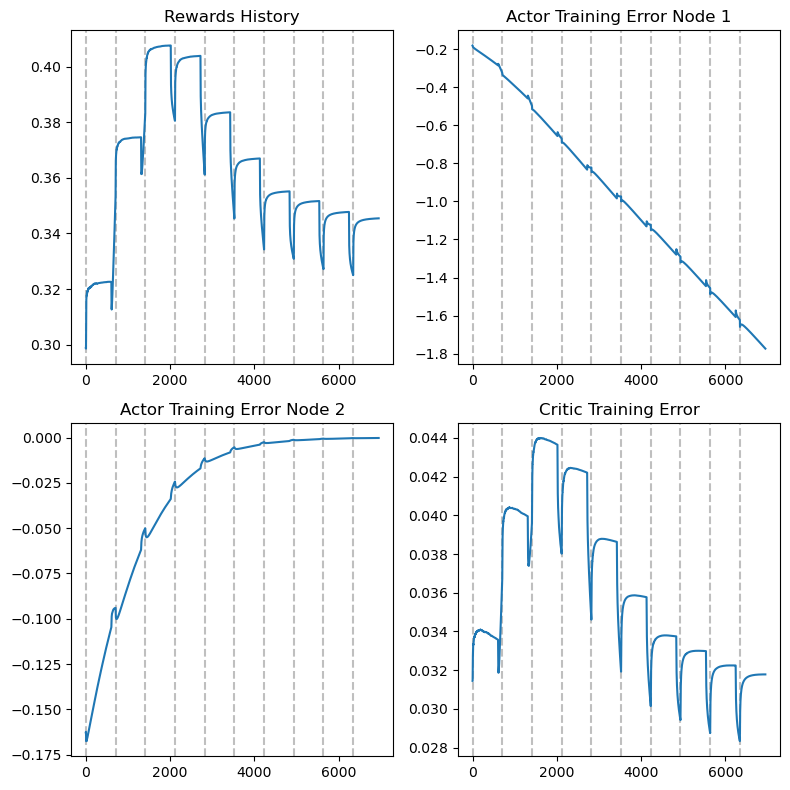

In [ ]:
training_viz(reward_history_d[:,3],actor_loss_history_d,critic_loss_history_d[:,0,0],100)

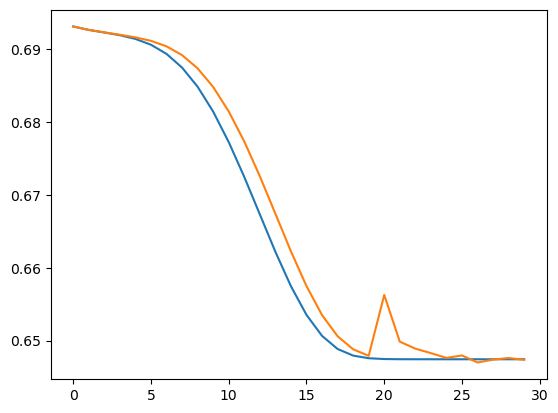

In [ ]:
plt.plot(loss_FM_d)
plt.plot(loss_AM_d)
plt.show()

In [ ]:
def mask_generate_shallowCovNet(actor, shallowcov, X):
    features = shallowcov.embedding(np.array([X]))
    agg_wo_current = np.zeros((features.shape[0], features.shape[-1]))
    num_added = np.zeros((features.shape[0], features.shape[-1])) # To estimate the denominator.
    mask = np.zeros(features.shape) # Mask generated by the agent module
    for t in tqdm(range(features.shape[-2] - 1)): # t = 1,...,T'
        # print('epoch :',epoch, 'batch :', batch, 't :', t)
        deno1 = np.copy(num_added)
        deno2 = np.copy(num_added) + 1 # For the features with the current segment.
        # To avoid zero-division.
        deno1[deno1 == 0] = 1.
        
        agg_w_current = agg_wo_current + features[:, 0, t, :]
        
        # Define state, s_t.
        state = np.concatenate((agg_wo_current/deno1, agg_w_current/deno2), axis=-1)
        # Get action, a_t.
        action_probs = actor(state)
        action = np.tile(tf.random.categorical(action_probs, 1).numpy(), 40) # (5, 112)
        mask[:, 0, t, :] = action
        num_added += action
        
        # Current feature after action decision, phi_t.
        deno3 = np.copy(num_added)
        deno3[deno3 == 0] = 1 # To avoid zero-division.
        agg_wo_current = (agg_wo_current + features[:, 0, t, :] * action)/deno3
    return mask
mask_d = mask_generate_shallowCovNet(actor_d, shallowcov_AM_d, X_train[1,:,:,:])
mask_d

100%|██████████| 705/705 [00:00<00:00, 940.05it/s]


array([[[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [0., 0., 0., ..., 0., 0., 0.]]]])

In [ ]:
import pywt

X = epochs_d.get_data()
y = epochs_d.events[:, -1]

csp_wt = CSP(n_components = 20, reg=None, log=None, norm_trace=False, transform_into='csp_space')
csp_wt.fit(X, y)

data_wt = csp_wt.transform(X)

train_size = len(y)
train_data_cwt = np.ndarray(shape=(train_size ,X.shape[1], 8, X.shape[2],))
print(train_data_cwt.shape)
scales = range(8,16)

scales = range(8,16)

for ii in range(45):
    for jj in range(20):
        signal = data_wt[ii, jj, :]
        coeff, _ = pywt.cwt(signal, scales, 'morl', 1)
        coeff_ = coeff[:, :X.shape[2]]  # (8,epochs_data.shape[2])
        train_data_cwt[ii, jj, :, :] = np.abs(coeff_)  

print(np.shape(coeff),np.shape(coeff_))

C:\Users\user\AppData\Local\Temp\ipykernel_33720\2898784890.py:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = epochs_d.get_data()


(45, 20, 8, 721)
(8, 721) (8, 721)


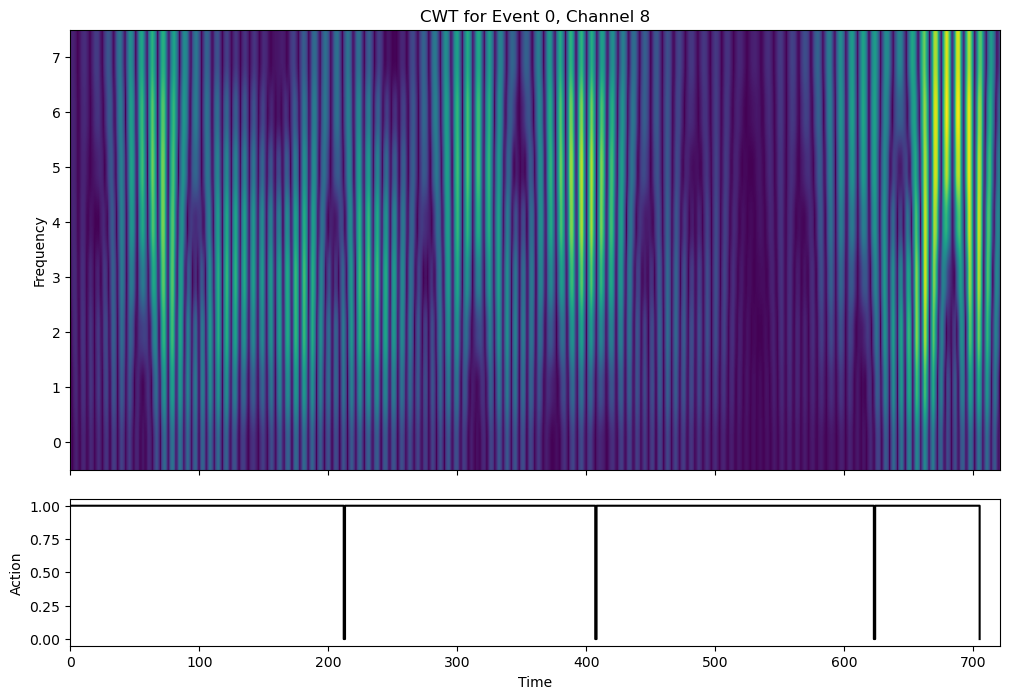

In [ ]:
event = 0
channel = 8

# Select the CWT data for the specific event and channel
cwt_slice = train_data_cwt[event, channel, :, :]
binary_mask = mask_d[0, 0, :, channel]

# Create the figure and two subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True, 
                               gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.1})

# Plot the CWT
im = ax1.imshow(cwt_slice, aspect='auto', cmap='viridis', origin='lower')
ax1.set_ylabel('Frequency')
ax1.set_title(f'CWT for Event {event}, Channel {channel}')
# fig.colorbar(im, ax=ax1, label='Intensity')

# Plot the binary mask
time = np.arange(0,706)  # Assuming the time axis matches the CWT data
ax2.plot(time, binary_mask, drawstyle='steps-post', color='black')
ax2.set_xlabel('Time')
ax2.set_ylabel('Action')

# Set x-axis limits
ax1.set_xlim(0, 721)
ax2.set_xlim(0, 721)


# Show the plot
plt.show()

## **Subject Dependent (CPS)**

In [ ]:
# --- Data Details --- 
subject_id_dcsp = []
for i in range(1,2):
    subject_id_dcsp.append(f'{i:003d}')
print(subject_id_dcsp)
    
task_id_dcsp = ["04", "08", "12"]

# --- Set Montage ---
montage_name_dcsp = 'standard_1020'

# --- Set Channels Select ---
chans_selected_dcsp = ['FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6',
                  'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'Cz',
                  'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'CPz']

# --- Set event ---
event_dcsp = {'left': 2, 'right': 3}
target_dcsp = ['left','right']
numclass_dcsp = [2,3]

streams_dcsp = load_data(subject_id_dcsp, task_id_dcsp, montage_name_dcsp)

['001']


In [ ]:
streams_dcsp.get_data().shape

(64, 60000)

c:\Anaconda\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


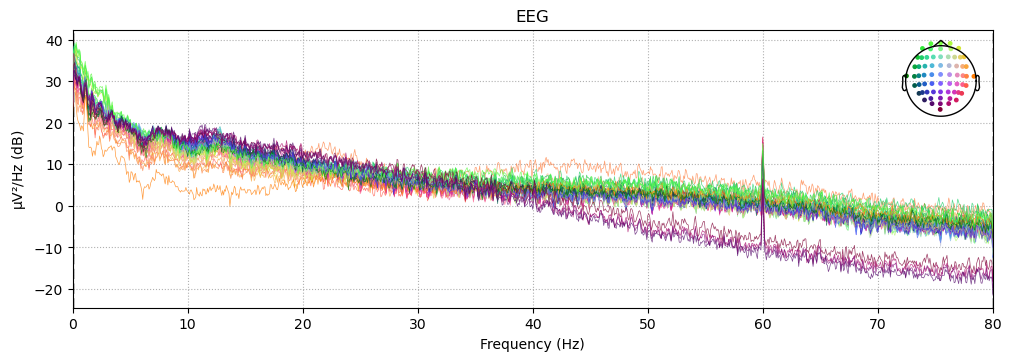

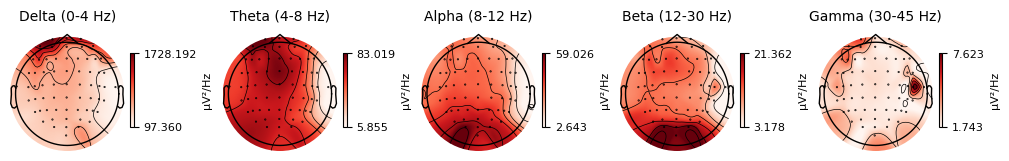

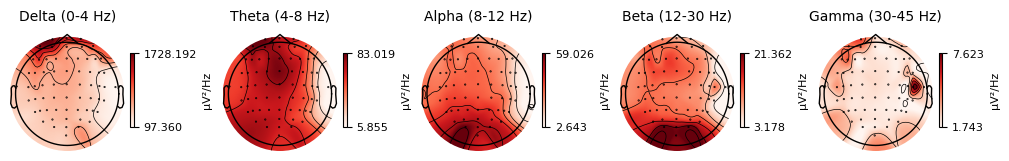

In [ ]:
streams_dcsp.compute_psd().plot();
streams_dcsp.compute_psd().plot_topomap()

In [ ]:
epochs_dcsp = preprocessing(streams_dcsp, event_dcsp, chans_selected_dcsp)
epochs_dcsp

Estimating rejection dictionary for eeg


Number of events,45
Events,left: 23right: 22
Time range,-0.500 – 4.000 s
Baseline,-0.500 – 0.000 s


c:\Anaconda\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


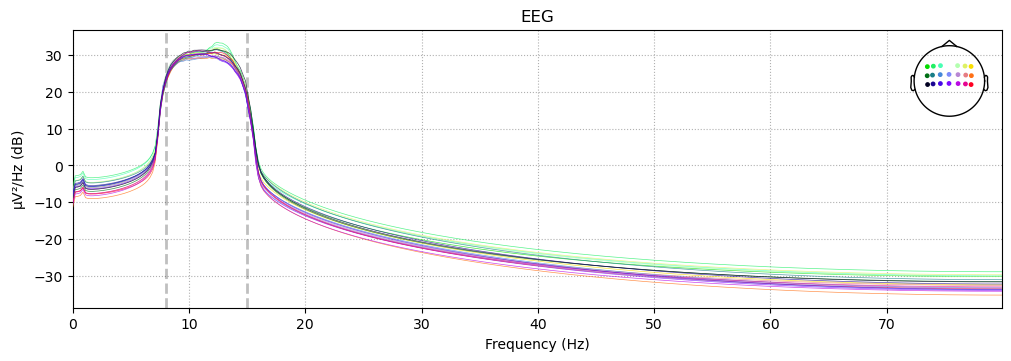

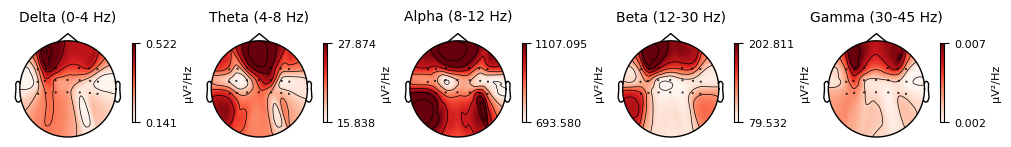

In [ ]:
epochs_dcsp.compute_psd().plot()
epochs_dcsp.compute_psd().plot_topomap();

In [ ]:
data_dcsp = epochs_dcsp.get_data(copy=True)

train_X_dcsp = np.expand_dims(np.moveaxis(data_dcsp, 0, 0), -1)
train_X_dcsp.shape

(45, 20, 721, 1)

In [ ]:
encoder = OneHotEncoder(sparse_output=False)

y_dcsp = epochs_dcsp.events[:, -1]
y_dcsp = encoder.fit_transform(np.array(y_dcsp).reshape(-1, 1))
y_dcsp.shape

(45, 2)

In [ ]:
X_train_dcsp, X_test_dcsp, y_train_dcsp, y_test_dcsp = train_test_split(train_X_dcsp, y_dcsp, test_size=0.35, random_state=42)
print(f'Number of train set = {X_train_dcsp.shape[0]}')
print(f'Number of  test set = {X_test_dcsp.shape[0]}')

Number of train set = 29
Number of  test set = 16


In [ ]:
class Classifier(tf.keras.Model):
    tf.keras.backend.set_floatx("float64")
    def __init__(self):
        super(Classifier, self).__init__()
        # Regularizer
        self.regularizer = tf.keras.regularizers.L1L2(l1=.001, l2=.01)

         # Activation functions
        self.softmax = tf.keras.layers.Softmax()
        
        # Flatteninig
        self.flatten = tf.keras.layers.Flatten()

        # Dropout
        self.dropout = tf.keras.layers.Dropout(0.5)

        # Decision making
        self.dense = tf.keras.layers.Dense(2, activation=None, kernel_regularizer=self.regularizer)

    def classifier(self, feature):
        # Flattening, dropout, mapping into the decision nodes
        feature = self.flatten(feature)
        feature = self.dropout(feature)
        y_hat = self.softmax(self.dense(feature))
        return y_hat

    def GAP(self, feature):
        return tf.reduce_mean(feature, -2)

    def call(self, feature):
        # Global Average Pooling
        feature = self.GAP(feature)

        # Decision making
        y_hat = self.classifier(feature)
        return y_hat

In [ ]:
def gradient(model, inputs, labels, mask=None, csp=None):
    with tf.GradientTape() as tape:
        if mask is None:
            yhat = model(inputs)
        else:
            feature = model.GAP(np.transpose(np.array([csp.transform(inputs[:,:,:,0])]), (1,0,3,2)) * mask)
            yhat = model.classifier(feature)

        loss = tf.keras.losses.binary_crossentropy(labels, yhat)

    grad = tape.gradient(loss, model.trainable_variables)
    return loss, grad

In [ ]:
class experiment():
    def __init__(self, train_X, train_Y, test_X, test_Y):
        # Load dataset.
        self.Xtr, self.Ytr = train_X, train_Y
        self.Xts, self.Yts = test_X, test_Y
        self.Yts = np.argmax(self.Yts, axis=-1) # To use scikit-learn accuracy function
        
        # Randomize the training dataset.
        rand_idx = np.random.permutation(self.Xtr.shape[0])
        self.Xtr, self.Ytr = self.Xtr[rand_idx, :, :, :], self.Ytr[rand_idx, :]

        # Learning schedules
        self.init_LR = 1e-4
        self.num_epochs_pre = 20 # Pre-training epochs
        self.num_epochs = 40
        self.num_batch = 20
        self.optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=self.init_LR)
        
        # Call optimizer.
        self.num_batch_iter = int(self.Xtr.shape[0]/self.num_batch)
        
    def training_FM(self):
        print(f"Classification without agent module ------\n")

        # Call Dense Layer.
        classifier = Classifier()

        csp = CSP(n_components = 20, norm_trace = False, transform_into = 'csp_space')
        csp.fit(self.Xtr[:,:,:,0],np.argmax(self.Ytr, axis=-1))
        
        # To record the loss curve.
        loss_FM = []
        for epoch in range(self.num_epochs):
            loss_per_epoch = 0

            for batch in range(self.num_batch_iter):                                  
                # Sample minibatch.
                xb = self.Xtr[batch * self.num_batch : (batch + 1) * self.num_batch, :, :, :]
                yb = self.Ytr[batch * self.num_batch : (batch + 1) * self.num_batch, :]

                features = np.transpose(np.array([csp.transform(xb[:,:,:,0])]), (1,0,3,2))

                # Estimate loss
                loss, grads = gradient(classifier, features, yb)

                # Update the parameters
                self.optimizer.apply_gradients(zip(grads, classifier.trainable_variables))
                loss_FM.append(np.mean(loss))
                loss_per_epoch += np.mean(loss)

            loss_per_epoch /= self.num_batch_iter

            # Reporting
            print(f"Iteration {epoch + 1}, Training Loss {loss_per_epoch:>.04f}")
            
        # Test the learned model.
        Ytr_hat = np.argmax(classifier(np.transpose(np.array([csp.transform(self.Xtr[:,:,:,0])]), (1,0,3,2))), axis=-1)
        Yts_hat = np.argmax(classifier(np.transpose(np.array([csp.transform(self.Xts[:,:,:,0])]), (1,0,3,2))), axis=-1)
        # print(f"\nSubject {self.sbj_idx}, Session {self.sess_idx},\
        print(f"\nTraining accuracy: {accuracy_score(np.argmax(self.Ytr, axis=-1), Ytr_hat)}!")
        print(f"Testing accuracy: {accuracy_score(self.Yts, Yts_hat)}!\n")
        return loss_FM, csp, classifier
    
    def training_AM(self):
        print(f"Classification with agent module ---------\n")

        # Call Dense Layer..
        classifier = Classifier()

        csp = CSP(n_components = 20, norm_trace = False, transform_into = 'csp_space')
        csp.fit(self.Xtr[:,:,:,0],np.argmax(self.Ytr, axis=-1))
        
        # To record the loss curve.
        loss_AM = []
        # Pre-training without the agent module
        for epoch in range(self.num_epochs_pre):
            loss_per_epoch = 0

            for batch in range(self.num_batch_iter):
                # Sample minibatch.
                xb = self.Xtr[batch * self.num_batch : (batch + 1) * self.num_batch, :, :, :]
                yb = self.Ytr[batch * self.num_batch : (batch + 1) * self.num_batch, :]

                features = np.transpose(np.array([csp.transform(xb[:,:,:,0])]), (1,0,3,2))

                # Estimate loss
                loss, grads = gradient(classifier, features, yb)

                # Update the parameters
                self.optimizer.apply_gradients(zip(grads, classifier.trainable_variables))
                loss_AM.append(np.mean(loss))
                loss_per_epoch += np.mean(loss)

            loss_per_epoch /= self.num_batch_iter

            # Reporting
            print(f"Iteration {epoch + 1}, Training Loss {loss_per_epoch:>.04f}")
            
        # Call agent module.
        actor = ACTOR()
        critic = CRITIC()

        reward_history = []
        actor_loss_history = []
        critic_loss_history = []
        
        # Training with the agent module
        for epoch in range(self.num_epochs - self.num_epochs_pre):
            loss_per_epoch = 0
            
            for batch in range(self.num_batch_iter):
                # Sample minibatch.
                xb = self.Xtr[batch * self.num_batch : (batch + 1) * self.num_batch, :, :, :]
                yb = self.Ytr[batch * self.num_batch : (batch + 1) * self.num_batch, :]

                features = np.transpose(np.array([csp.transform(xb[:,:,:,0])]), (1,0,3,2))
                
                agg_wo_current = np.zeros((self.num_batch, features.shape[-1]))
                num_added = np.zeros((self.num_batch, features.shape[-1])) # To estimate the denominator.
                mask = np.zeros(features.shape) # Mask generated by the agent module
                for t in tqdm(range(features.shape[-2] - 1)): # t = 1,...,T'
                    # print('epoch :',epoch, 'batch :', batch, 't :', t)
                    deno1 = np.copy(num_added)
                    deno2 = np.copy(num_added) + 1 # For the features with the current segment.
                    # To avoid zero-division.
                    deno1[deno1 == 0] = 1.
                    
                    agg_w_current = agg_wo_current + features[:, 0, t, :]
                    
                    # Define state, s_t.
                    state = np.concatenate((agg_wo_current/deno1, agg_w_current/deno2), axis=-1)
                    # Get action, a_t.
                    action_probs = actor(state)
                    action = np.tile(tf.random.categorical(action_probs, 1).numpy(), 20) 
                    mask[:, 0, t, :] = action
                    num_added += action
                    
                    # Current feature after action decision, phi_t.
                    deno3 = np.copy(num_added)
                    deno3[deno3 == 0] = 1 # To avoid zero-division.
                    feature = (agg_wo_current + features[:, 0, t, :] * action)/deno3
                    
                    # Define next state, s_{t+1}, temporally.
                    agg_wo_current = feature
                    tmp = agg_wo_current + features[:, 0, t + 1, :]
                    state_next = np.concatenate((agg_wo_current/deno3, tmp/(deno3 + 1)), axis=-1)

                    # Calculate critic and actor loss values
                    critic_loss, critic_grads, actor_loss, actor_grads, reward = agent_gradient(classifier, actor, critic, xb, feature, yb, state, state_next)
                    
                    reward_history.append(reward.numpy())
                    actor_loss_history.append(actor_loss.numpy())
                    critic_loss_history.append(critic_loss.numpy())
                    
                    self.optimizer.apply_gradients(zip(critic_grads, critic.trainable_variables))
                    # print("critic :",critic.trainable_variables)
                    self.optimizer.apply_gradients(zip(actor_grads, actor.trainable_variables))
                                        
                # Finally, predict labels of input EEG using the selected segments.                
                # Update the parameters
                loss, grads = gradient(classifier, xb, yb, mask, csp)
                self.optimizer.apply_gradients(zip(grads, classifier.trainable_variables))
                loss_AM.append(np.mean(loss))
                loss_per_epoch += np.mean(loss)
                
            loss_per_epoch /= self.num_batch_iter

            # Reporting
            print(f"Iteration {epoch + 1 + self.num_epochs_pre}, Training Loss {loss_per_epoch:>.04f}")
        
        acc = []
        for X, Y in [(self.Xtr, np.argmax(self.Ytr, axis=-1)),(self.Xts, self.Yts)]:
            Y_hat = np.argmax(classifier(np.transpose(np.array([csp.transform(X[:,:,:,0])]), (1,0,3,2))), axis=-1)
            acc.append(accuracy_score(Y, Y_hat))

        # print(f"\nSubject {self.sbj_idx}, Session {self.sess_idx}, \
        print(f"\nTraining accuracy: {acc[0]}!")
        print(f"Testing accuracy: {acc[1]}!\n")
        return loss_AM, reward_history, actor_loss_history, critic_loss_history, actor, critic, csp, classifier

with tf.device('/gpu:1'):
    exp_dcsp = experiment(X_train_dcsp, y_train_dcsp, X_test_dcsp, y_test_dcsp)
    loss_FM_dcsp, csp_FM_dcsp, classifier_FM_dcsp = exp_dcsp.training_FM()
    loss_AM_dcsp, reward_history_dcsp, actor_loss_history_dcsp, critic_loss_history_dcsp, actor_dcsp, critic_dcsp, csp_AM_dcsp, classifier_AM_dcsp = exp_dcsp.training_AM()

Classification without agent module ------

Iteration 1, Training Loss 0.6846
Iteration 2, Training Loss 0.6846
Iteration 3, Training Loss 0.6845
Iteration 4, Training Loss 0.6845
Iteration 5, Training Loss 0.6844
Iteration 6, Training Loss 0.6844
Iteration 7, Training Loss 0.6844
Iteration 8, Training Loss 0.6843
Iteration 9, Training Loss 0.6843
Iteration 10, Training Loss 0.6843
Iteration 11, Training Loss 0.6843
Iteration 12, Training Loss 0.6842
Iteration 13, Training Loss 0.6842
Iteration 14, Training Loss 0.6842
Iteration 15, Training Loss 0.6842
Iteration 16, Training Loss 0.6842
Iteration 17, Training Loss 0.6841
Iteration 18, Training Loss 0.6841
Iteration 19, Training Loss 0.6841
Iteration 20, Training Loss 0.6841
Iteration 21, Training Loss 0.6841
Iteration 22, Training Loss 0.6840
Iteration 23, Training Loss 0.6840
Iteration 24, Training Loss 0.6840
Iteration 25, Training Loss 0.6840
Iteration 26, Training Loss 0.6839
Iteration 27, Training Loss 0.6839
Iteration 28, Traini

100%|██████████| 720/720 [00:13<00:00, 53.98it/s]


Iteration 21, Training Loss 0.6909


100%|██████████| 720/720 [00:14<00:00, 50.33it/s]


Iteration 22, Training Loss 0.6930


100%|██████████| 720/720 [00:14<00:00, 50.26it/s]


Iteration 23, Training Loss 0.6914


100%|██████████| 720/720 [00:15<00:00, 47.20it/s]


Iteration 24, Training Loss 0.6882


100%|██████████| 720/720 [00:12<00:00, 56.93it/s]


Iteration 25, Training Loss 0.6874


100%|██████████| 720/720 [00:12<00:00, 57.36it/s]


Iteration 26, Training Loss 0.6903


100%|██████████| 720/720 [00:12<00:00, 57.03it/s]


Iteration 27, Training Loss 0.6896


100%|██████████| 720/720 [00:14<00:00, 50.44it/s]


Iteration 28, Training Loss 0.6915


100%|██████████| 720/720 [00:12<00:00, 57.51it/s]


Iteration 29, Training Loss 0.6906


100%|██████████| 720/720 [00:12<00:00, 56.49it/s]


Iteration 30, Training Loss 0.6864


100%|██████████| 720/720 [00:12<00:00, 57.08it/s]


Iteration 31, Training Loss 0.6877


100%|██████████| 720/720 [00:12<00:00, 57.47it/s]


Iteration 32, Training Loss 0.6866


100%|██████████| 720/720 [00:12<00:00, 57.23it/s]


Iteration 33, Training Loss 0.6876


100%|██████████| 720/720 [00:12<00:00, 56.77it/s]


Iteration 34, Training Loss 0.6853


100%|██████████| 720/720 [00:12<00:00, 57.29it/s]


Iteration 35, Training Loss 0.6882


100%|██████████| 720/720 [00:12<00:00, 57.65it/s]


Iteration 36, Training Loss 0.6924


100%|██████████| 720/720 [00:12<00:00, 56.98it/s]


Iteration 37, Training Loss 0.6852


100%|██████████| 720/720 [00:12<00:00, 56.99it/s]


Iteration 38, Training Loss 0.6869


100%|██████████| 720/720 [00:13<00:00, 53.83it/s]


Iteration 39, Training Loss 0.6853


100%|██████████| 720/720 [00:12<00:00, 56.00it/s]

Iteration 40, Training Loss 0.6911

Training accuracy: 0.5172413793103449!
Testing accuracy: 0.625!



In [ ]:
reward_history_dcsp = np.array(reward_history_dcsp)
batch_mean_reward_history_dcsp = np.mean(reward_history_dcsp, axis = 1)
actor_loss_history_dcsp = np.array(actor_loss_history_dcsp)
critic_loss_history_dcsp = np.array(critic_loss_history_dcsp)

batch_mean_reward_log_dcsp = []
for i in range(int(reward_history_dcsp.shape[0]/705)):
    batch_mean_reward_log_dcsp.append(batch_mean_reward_history_dcsp[i*705:(i+1)*705])

batch_mean_reward_log_dcsp = np.sum(np.array(batch_mean_reward_log_dcsp), axis = 1)

In [ ]:
actor_loss_history_dcsp

array([[[-3.22196173e-02, -3.42486611e-02],
        [-3.21214121e-02, -3.13455490e-02],
        [-6.53586647e-03, -6.54303932e-03],
        ...,
        [ 1.07259253e-02,  1.17172486e-02],
        [ 4.48274004e-02,  4.58768436e-02],
        [-2.44509906e-02, -2.45386171e-02]],

       [[-1.71158198e-02, -1.39941162e-02],
        [-2.51435946e+00, -2.67086523e+00],
        [ 4.80996364e-03,  5.37474414e-03],
        ...,
        [-2.40884925e-02, -1.59381478e-02],
        [-7.86185045e-02, -7.17252858e-02],
        [ 6.15626830e-02,  3.13978865e-02]],

       [[-8.74666734e-01, -5.46804216e-01],
        [-9.71750948e+00, -9.71317477e-01],
        [ 5.29916908e-03,  5.95838534e-03],
        ...,
        [-7.14762785e-02, -3.14380173e-02],
        [-9.41825715e-02, -7.50293207e-02],
        [ 8.98212789e-02,  4.00983921e-02]],

       ...,

       [[-2.89496251e-02, -6.37685933e-04],
        [-2.94224208e-02, -6.53232256e-04],
        [-2.49736188e-02, -5.48153390e-04],
        ...,
     

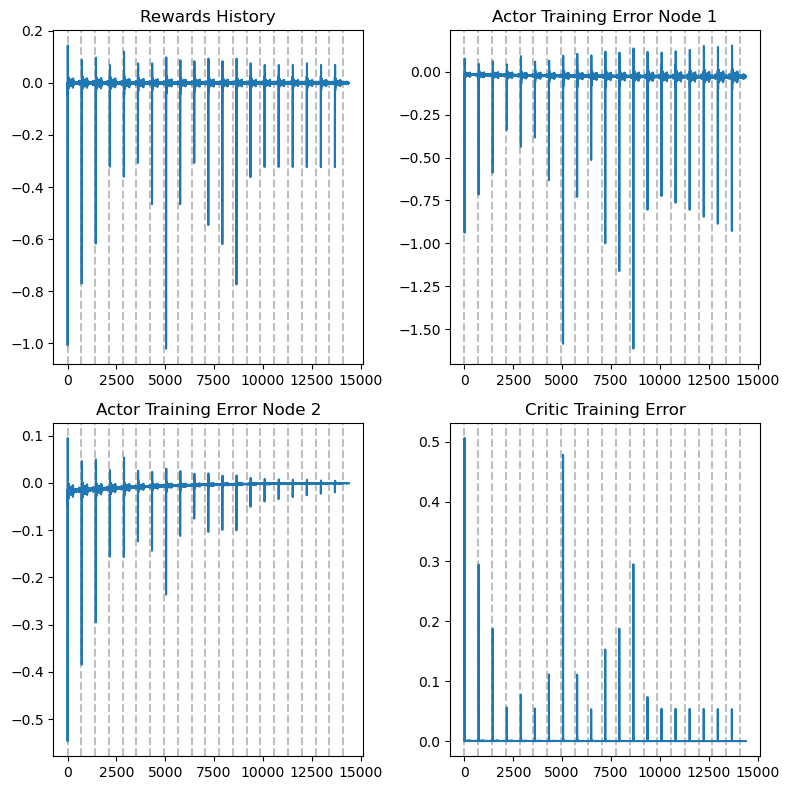

In [ ]:
training_viz(reward_history_dcsp[:,0],actor_loss_history_dcsp,critic_loss_history_dcsp[:,0,0],1)

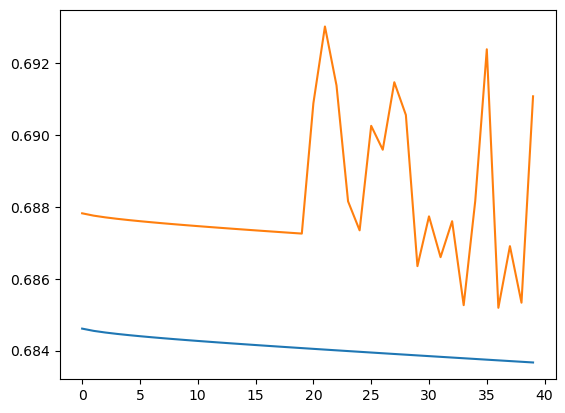

In [ ]:
plt.plot(loss_FM_dcsp)
plt.plot(loss_AM_dcsp)
plt.show()

In [ ]:
def mask_generate_csp(actor, csp, X):
    features = np.transpose(np.array([csp.transform(np.array([X]))]), (1,0,3,2))
    agg_wo_current = np.zeros((features.shape[0], features.shape[-1]))
    num_added = np.zeros((features.shape[0], features.shape[-1])) # To estimate the denominator.
    mask = np.zeros(features.shape) # Mask generated by the agent module
    for t in tqdm(range(features.shape[-2] - 1)): # t = 1,...,T'
        # print('epoch :',epoch, 'batch :', batch, 't :', t)
        deno1 = np.copy(num_added)
        deno2 = np.copy(num_added) + 1 # For the features with the current segment.
        # To avoid zero-division.
        deno1[deno1 == 0] = 1.
        
        agg_w_current = agg_wo_current + features[:, 0, t, :]
        
        # Define state, s_t.
        state = np.concatenate((agg_wo_current/deno1, agg_w_current/deno2), axis=-1)
        # Get action, a_t.
        action_probs = actor(state)
        action = np.tile(tf.random.categorical(action_probs, 1).numpy(), 20)
        mask[:, 0, t, :] = action
        num_added += action
        
        # Current feature after action decision, phi_t.
        deno3 = np.copy(num_added)
        deno3[deno3 == 0] = 1 # To avoid zero-division.
        agg_wo_current = (agg_wo_current + features[:, 0, t, :] * action)/deno3
    return mask
mask = mask_generate_csp(actor_dcsp, csp_AM_dcsp, X_train_dcsp[1,:,:,0])
mask

100%|██████████| 720/720 [00:00<00:00, 2165.40it/s]


array([[[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [0., 0., 0., ..., 0., 0., 0.]]]])

In [ ]:
import pywt

X = epochs_dcsp.get_data()
y = epochs_dcsp.events[:, -1]

csp_wt = CSP(n_components = 20, reg=None, log=None, norm_trace=False, transform_into='csp_space')
csp_wt.fit(X, y)

data_wt = csp_wt.transform(X)

train_size = len(y)
train_data_cwt = np.ndarray(shape=(train_size ,X.shape[1], 8, X.shape[2],))
print(train_data_cwt.shape)
scales = range(8,16)

scales = range(8,16)

for ii in range(45):
    for jj in range(20):
        signal = data_wt[ii, jj, :]
        coeff, _ = pywt.cwt(signal, scales, 'morl', 1)
        coeff_ = coeff[:, :X.shape[2]]  # (8,epochs_data.shape[2])
        train_data_cwt[ii, jj, :, :] = np.abs(coeff_)  

print(np.shape(coeff),np.shape(coeff_))

C:\Users\user\AppData\Local\Temp\ipykernel_33720\2499089003.py:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = epochs_dcsp.get_data()


(45, 20, 8, 721)
(8, 721) (8, 721)


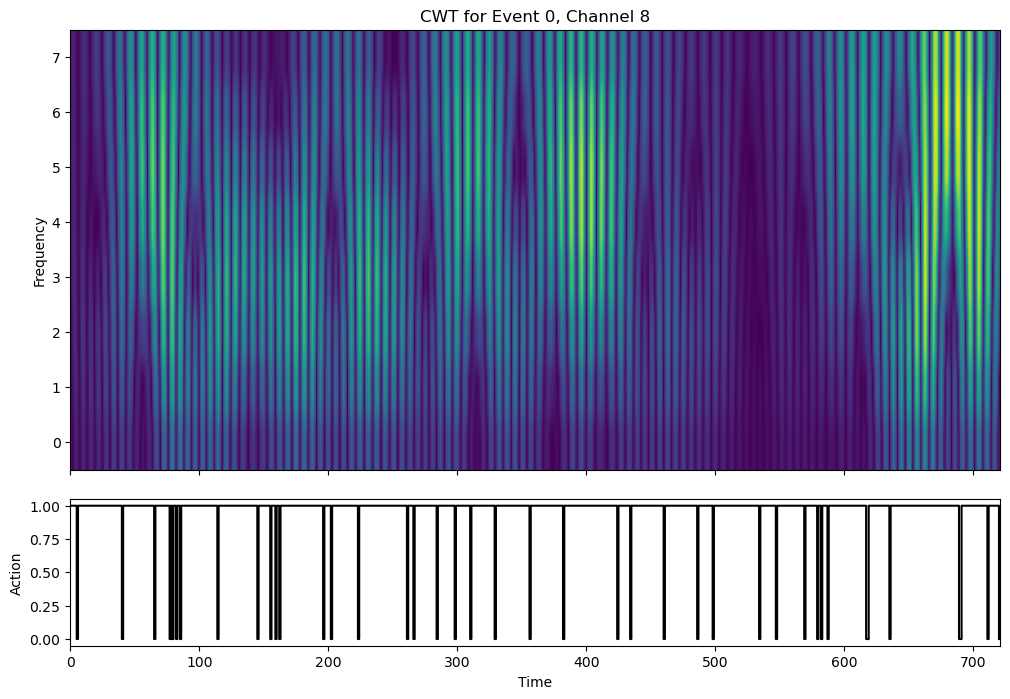

In [ ]:
event = 0
channel = 8

# Select the CWT data for the specific event and channel
cwt_slice = train_data_cwt[event, channel, :, :]
binary_mask = mask[0, 0, :, channel]

# Create the figure and two subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True, 
                               gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.1})

# Plot the CWT
im = ax1.imshow(cwt_slice, aspect='auto', cmap='viridis', origin='lower')
ax1.set_ylabel('Frequency')
ax1.set_title(f'CWT for Event {event}, Channel {channel}')
# fig.colorbar(im, ax=ax1, label='Intensity')

# Plot the binary mask
time = np.arange(0,721)  # Assuming the time axis matches the CWT data
ax2.plot(time, binary_mask, drawstyle='steps-post', color='black')
ax2.set_xlabel('Time')
ax2.set_ylabel('Action')

# Set x-axis limits
ax1.set_xlim(0, 721)
ax2.set_xlim(0, 721)


# Show the plot
plt.show()
